## Predizendo a evasão de clientes de Telecom - CHURN -

### Sobre a base de dados 🎲

Este conjunto de dados vem de uma empresa de telecomunicações iraniana, com cada linha representando um cliente ao longo de um período de um ano. Junto com um rótulo de rotatividade, há informações sobre a atividade dos clientes, como falhas de chamada e duração da assinatura.

### Nossos objetivos 🚀

Redução do churn de clientes da empresa.
O conjunto de dados inclui diversas informações sobre o uso do plano por parte dos clientes. O problema é formulado como uma tarefa de classificação de duas categorias (Churn e Não Churn).

- Criar modelos uma pipeline preditiva de um modelo de classificação 🎯


### Sobre a fonte de dados:

Este conjunto de dados é disponibilizado pelo Datalab.

https://www.datacamp.com/datalab/datasets/dataset-python-telecom-customer-churn



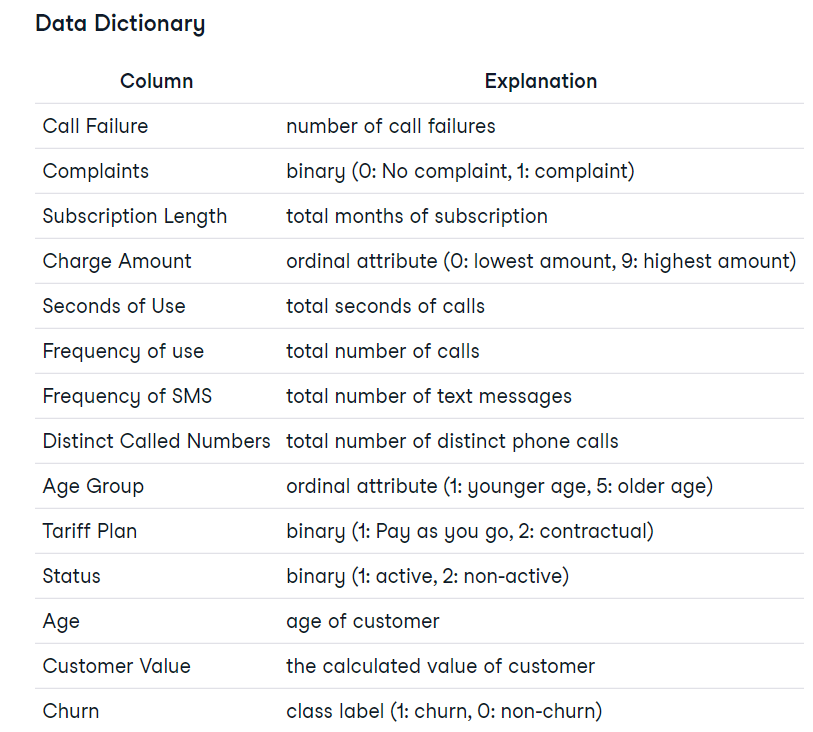

## Analisando a qualidade dos dados 🧹🎲

In [ ]:
import datetime
import pyarrow.parquet as pq
import pyarrow as pa
from os.path import getmtime
from pathlib import Path
import time
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
## CARREGAR O ARQUIVO ##

df = pd.read_csv('datalab_churn.csv',  encoding='windows-1252')
df.head(5)

,"ï»¿""index""",Call Failure,Complaints,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


In [ ]:
## TRATAR OS DADOS DATAFRAME ##

df.columns = [
'Indice',
'Falha de chamada',
'Reclamacoes',
'Duracao da assinatura',
'Valor da cobranca',
'Segundos de uso',
'Frequência de uso',
'Frequência de SMS',
'Números distintos chamados',
'Faixa etaria',
'Plano tarifario',
'Status',
'Idade',
'Valor do cliente',
'Churn']

df = df.drop('Indice', axis=1)

In [ ]:
df.head(5)

,Falha de chamada,Reclamacoes,Duracao da assinatura,Valor da cobranca,Segundos de uso,Frequência de uso,Frequência de SMS,Números distintos chamados,Faixa etaria,Plano tarifario,Status,Idade,Valor do cliente,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


In [ ]:
df.shape

(3099, 14)

In [ ]:
df.dropna(inplace=True)
df.shape

(3099, 14)

### **Conhecendo os dados** 👋

- Índice (removido)
- Falha de chamada
- Reclamações (0: sem reclamação, 1: reclamação)
- Duração da assinatura
- Valor da cobrança (0: menor valor, 9: maior valor)
- Segundos de uso
- Frequência de uso
- Frequência de SMS
- Números distintos chamados
- Faixa etária  (1: idade mais jovem, 5: idade mais avançada)
- Plano tarifário (1: pré-pago, 2: contratual)
- Status (1: Ativo, 2: Não Ativo)
- Idade
- Valor do cliente
- Churn (1: churn, 0: Não churn)

In [ ]:
set(df['Churn'])

{0, 1}

In [ ]:
df['Churn'] = df['Churn'].replace({0 : 'Não churn', 1 : 'Churn'})

<Axes: ylabel='Frequency'>

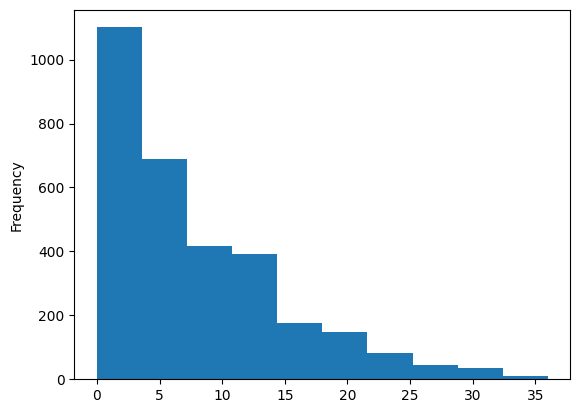

In [ ]:
df['Falha de chamada'].plot(kind='hist')
#df['Falha de chamada'].plot()

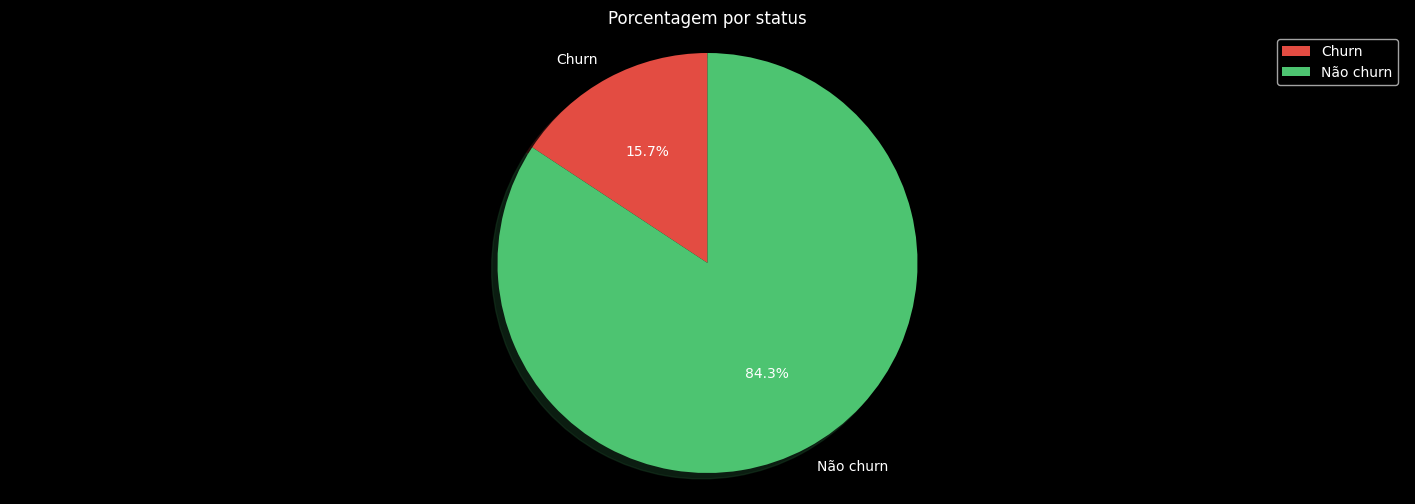

In [ ]:
#Calcular o total de clientes por tipo de status
df_targets_percent = df.groupby('Churn')['Churn'].count()

# Calculando a proporção de clientes por categporia
total_clientes = len(df)
df_target_porcentagem = df_targets_percent / total_clientes * 100

#Separando os valores e nomes em uma lista, para deixar o gráfico mais apresentável
labels = df_target_porcentagem.index.tolist()
sizes = df_target_porcentagem.values.tolist()

#Criando o gráfico
plt.style.use('dark_background')
figura, grafico = plt.subplots(figsize=(18, 6))
#grafico.pie(sizes, autopct='%1.0f%%', colors=[ '#e34c42','#4dc471'], labeldistance = 1.1, explode=[0, 0, .4])
grafico.pie(sizes, labels=labels, autopct='%1.1f%%',colors=[ '#e34c42','#4dc471'], shadow=True, startangle=90)
grafico.axis('equal')
plt.title('Porcentagem por status')
plt.legend(labels, loc='best')
plt.show()

In [ ]:
df_targets_percent

,Churn
Churn,
Churn,487
Não churn,2612


OK, podemos concluir aqui que 84,3% da base contém clientes atuais e 15,7% de clientes que sairam da carteira.

## Validando o equilíbrio das targets 🎯

In [ ]:
df_concatenado = df

round(df_concatenado['Churn'].value_counts(normalize = True)*100,2)

,proportion
Churn,
Não churn,84.29
Churn,15.71


Como podemos observar, a base de dados possui maior concentração de amostras para os clientes na base, o que pode ser um comportamento natural em uma empresa de Telecom, mas será que este problema de desequilíbrio pode afetar o aprendizado de máquina? Claramente, sim! O desequilíbrio de classes é um problema muito comum neste mundo de aprendizado de máquina e pode ser tratado de vários jeitos:

* Coleta de mais amostras das classes minoritárias.
* Aplicação de técnica de undersampling ou oversampling.

Neste notebook, vamos testar o undersampling.

In [ ]:
df_concatenado['Churn'] = df_concatenado['Churn'].replace({'Não churn' : 0, 'Churn': 1}) #binário

X = df_concatenado[['Falha de chamada','Reclamacoes','Duracao da assinatura','Valor da cobranca','Segundos de uso',
                    'Frequência de uso','Frequência de SMS','Números distintos chamados','Faixa etaria','Plano tarifario','Status',
                    'Idade','Valor do cliente']] #caracteristicas

y = df_concatenado['Churn'] #target

In [ ]:
! pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import MinMaxScaler

# Separar as variáveis numéricas e categóricas
categorical_cols = ['Reclamacoes','Faixa etaria','Plano tarifario','Status']
numerical_cols = ['Falha de chamada','Duracao da assinatura','Valor da cobranca','Segundos de uso',
                  'Frequência de uso','Frequência de SMS','Números distintos chamados',
                  'Idade','Valor do cliente']

# Criar o pipeline
pipeline = Pipeline([
    ('encoder', CatBoostEncoder(cols=categorical_cols, random_state=42)),
    ('scaler', MinMaxScaler())
])

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar o pipeline aos dados de treino
X_train_transformed = pipeline.fit_transform(X_train, y_train)

# Aplicar o pipeline aos dados de teste (usando o fit do treino)
X_test_transformed = pipeline.transform(X_test)

In [ ]:
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import cross_val_predict

def treinar_e_avaliar_modelo(modelo, X_train_transformed, y_train, X_test_transformed, y_test):
    # Treinar o modelo com validação cruzada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Validação cruzada estratificada
    y_pred = cross_val_predict(modelo, X_train_transformed, y_train, cv=cv)

    # Avaliar o modelo na base de treino
    #print("Relatório de Classificação (Treino):")
    #print(classification_report(y_train, y_pred))

    # Calcular a curva ROC na base de treino
    y_prob = cross_val_predict(modelo, X_train_transformed, y_train, cv=cv, method='predict_proba')[:, 1]
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_prob)
    roc_auc_train = auc(fpr_train, tpr_train)

    # Avaliar o modelo na base de teste
    y_pred_test = modelo.predict(X_test_transformed)
    print("\nRelatório de Classificação (Teste):")
    print(classification_report(y_test, y_pred_test))

    # Calcular a curva ROC na base de teste
    y_prob_test = modelo.predict_proba(X_test_transformed)[:, 1]
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_prob_test)
    roc_auc_test = auc(fpr_test, tpr_test)

    # Plotar a curva ROC (treino e teste)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Curva ROC (Treino) (área = {roc_auc_train:.2f})')
    plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Curva ROC (Teste) (área = {roc_auc_test:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC (Treino e Teste)')
    plt.legend(loc="lower right")
    plt.show()

## Regressão Logística

In [ ]:
from sklearn.linear_model import LogisticRegression
# Criando e treinando o modelo de Regressão Logística
modelo_rl = LogisticRegression()
modelo_rl.fit(X_train_transformed, y_train)

LogisticRegression()

In [ ]:
# Fazendo previsões sobre o conjunto de dados de teste
y_pred = modelo_rl.predict(X_test)

In [ ]:
y_pred[:5]

array([0, 0, 0, 0, 0])

In [ ]:
y_test[:5]

,Churn
718,1
2953,0
1805,0
1612,0
1190,0


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="micro")
recall = recall_score(y_test, y_pred, average="micro")
f1 = f1_score(y_test, y_pred, average="micro")

print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Revocação:", recall)
print("F1-Score:", f1)

Acurácia: 0.8451612903225807
Precisão: 0.8451612903225807
Revocação: 0.8451612903225807
F1-Score: 0.8451612903225807


 ## Arvore de Decisão

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# Criando e treinando o modelo de Árvore de Decisão
modelo = DecisionTreeClassifier()
modelo.fit(X_train_transformed, y_train)
# Fazendo previsões sobre o conjunto de dados de teste
y_pred = modelo.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="micro")
recall = recall_score(y_test, y_pred, average="micro")
f1 = f1_score(y_test, y_pred, average="micro")

print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Revocação:", recall)
print("F1-Score:", f1)

Acurácia: 0.10967741935483871
Precisão: 0.10967741935483871
Revocação: 0.10967741935483871
F1-Score: 0.10967741935483871


## KNN


Relatório de Classificação (Teste):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       524
           1       0.82      0.82      0.82        96

    accuracy                           0.95       620
   macro avg       0.90      0.90      0.90       620
weighted avg       0.95      0.95      0.95       620



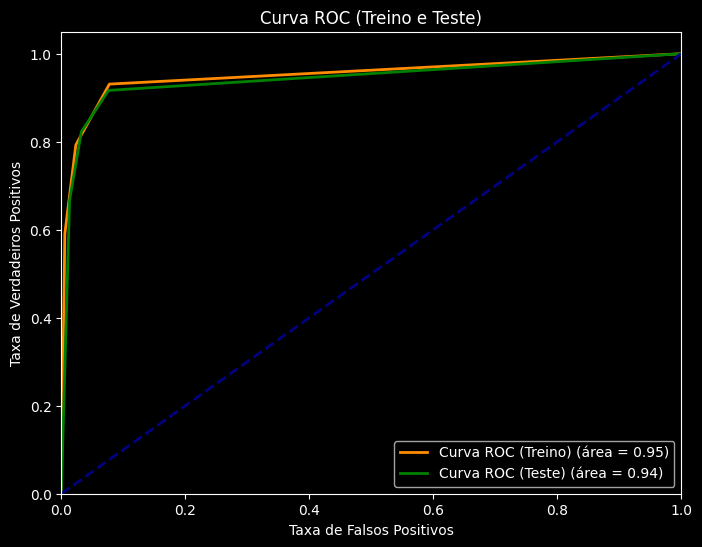

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# Inicializar e treinar o modelo (exemplo com KNN)
modelo_knn = KNeighborsClassifier(n_neighbors=3)
modelo_knn.fit(X_train_transformed, y_train)

# Avaliar o modelo
treinar_e_avaliar_modelo(modelo_knn, X_train_transformed, y_train, X_test_transformed, y_test)


 ## Random Forest


Relatório de Classificação (Teste):
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       524
           1       0.86      0.81      0.83        96

    accuracy                           0.95       620
   macro avg       0.91      0.89      0.90       620
weighted avg       0.95      0.95      0.95       620



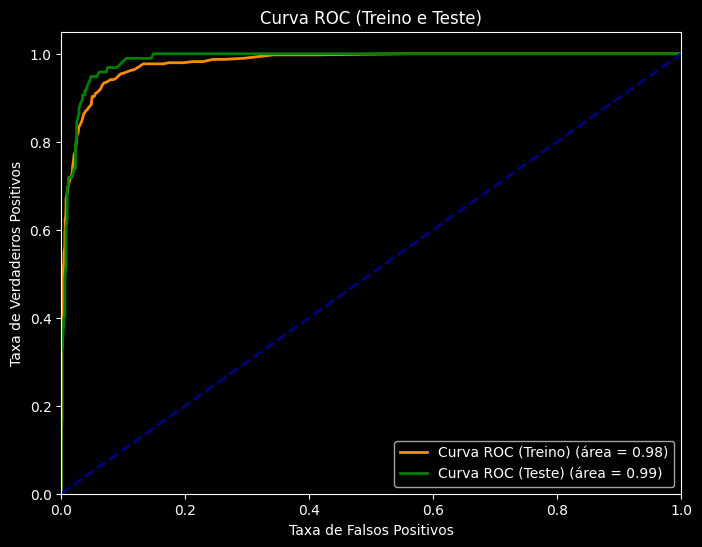

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Inicializar e treinar o modelo (exemplo com RandomForestClassifier)
modelo = RandomForestClassifier(random_state=42)
modelo.fit(X_train_transformed, y_train)

# Avaliar o modelo
treinar_e_avaliar_modelo(modelo, X_train_transformed, y_train, X_test_transformed, y_test)

# Feature Importance

A técnica de  Feature Importance auxilia na compreensão das features que são mais impactantes e discriminantes para os modelos de aprendizado de máquina.  Essa técnica pode até mesmo auxiliar na interpretação dos resultados do modelo.

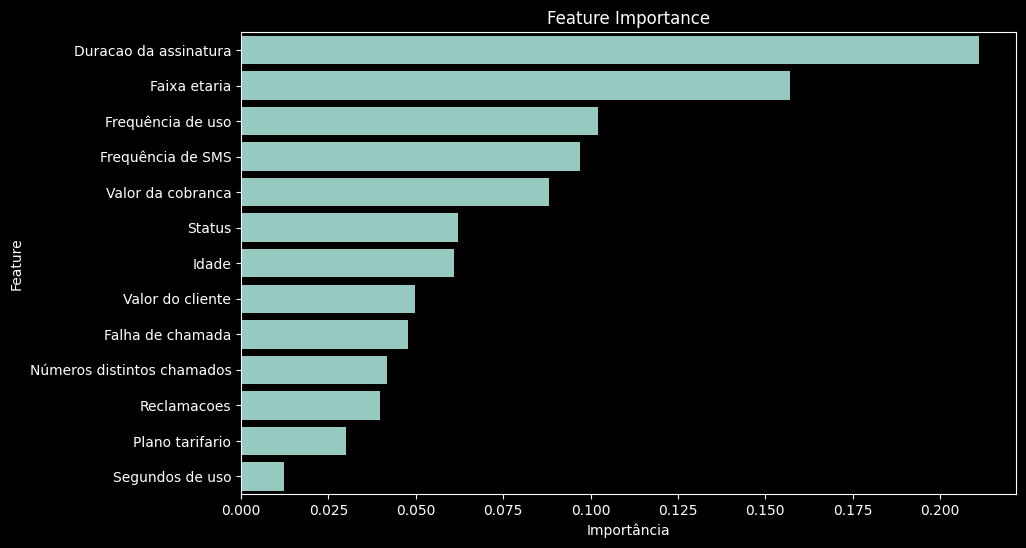

In [ ]:
# Feature Importance
feature_importances = modelo.feature_importances_
feature_names = numerical_cols + categorical_cols

# Criar DataFrame para visualização
df_feature_importance = pd.DataFrame({'Feature': feature_names, 'Importância': feature_importances})
df_feature_importance = df_feature_importance.sort_values(by='Importância', ascending=False)


# Plotar o gráfico de Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importância', y='Feature', data=df_feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.show()

# **Equilibrando a target ⚖️**

Undersampling é uma técnica de pré-processamento usada em problemas de classificação, especialmente quando há um desequilíbrio significativo entre as classes, ou seja, uma classe está muito mais presente do que a outra. O objetivo do undersampling é balancear a distribuição das classes para melhorar o desempenho do modelo.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Inicializa o RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Aplica o undersampling no conjunto de dados
X_resampled, y_resampled = rus.fit_resample(df_concatenado.drop('Churn', axis=1), df_concatenado['Churn'])

# Cria um novo DataFrame com os dados balanceados
df_balanced = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['Churn'])], axis=1)

df_balanced.shape

(974, 14)

In [ ]:
df_balanced['Churn'].value_counts()

,count
Churn,
0,487
1,487


# Testando a pipeline com os dados equilibrados  🎯

In [ ]:
X = df_balanced[['Falha de chamada','Reclamacoes','Duracao da assinatura','Valor da cobranca','Segundos de uso',
                    'Frequência de uso','Frequência de SMS','Números distintos chamados','Faixa etaria','Plano tarifario','Status',
                    'Idade','Valor do cliente']] #caracteristicas

y = df_balanced['Churn'] #target

In [ ]:
# Separar as variáveis numéricas e categóricas
categorical_cols = ['Reclamacoes','Faixa etaria','Plano tarifario','Status']
numerical_cols = ['Falha de chamada','Duracao da assinatura','Valor da cobranca','Segundos de uso',
                  'Frequência de uso','Frequência de SMS','Números distintos chamados',
                  'Idade','Valor do cliente']

# Criar o pipeline
pipeline = Pipeline([
    ('encoder', CatBoostEncoder(cols=categorical_cols, random_state=42)),
    ('scaler', MinMaxScaler())
])

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar o pipeline aos dados de treino
X_train_transformed = pipeline.fit_transform(X_train, y_train)

# Aplicar o pipeline aos dados de teste (usando o fit do treino)
X_test_transformed = pipeline.transform(X_test)

# Dados equilibrados - Random Forest  ##



Relatório de Classificação (Teste):
              precision    recall  f1-score   support

           0       0.96      0.91      0.93        98
           1       0.91      0.96      0.93        97

    accuracy                           0.93       195
   macro avg       0.93      0.93      0.93       195
weighted avg       0.93      0.93      0.93       195



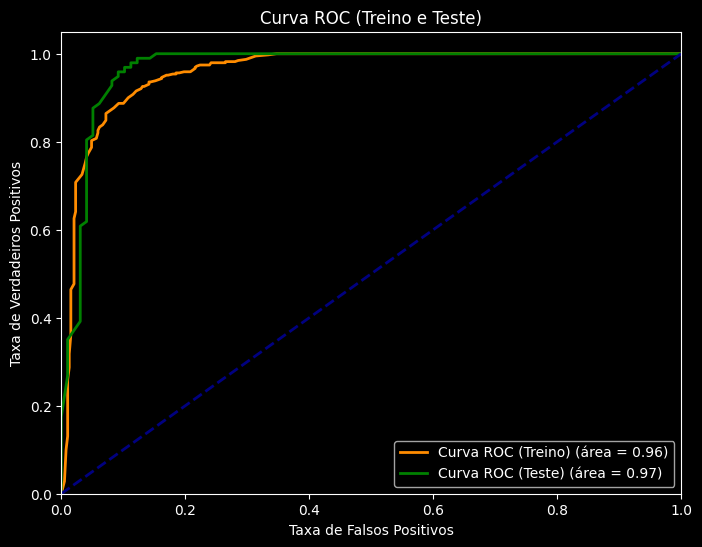

In [ ]:
modelo_upgrade = RandomForestClassifier(random_state=42)
modelo_upgrade.fit(X_train_transformed, y_train)

# Avaliar o modelo
treinar_e_avaliar_modelo(modelo_upgrade, X_train_transformed, y_train, X_test_transformed, y_test)

# Dados equilibrados - KNN  ##


Relatório de Classificação (Teste):
              precision    recall  f1-score   support

           0       0.91      0.88      0.90        98
           1       0.88      0.92      0.90        97

    accuracy                           0.90       195
   macro avg       0.90      0.90      0.90       195
weighted avg       0.90      0.90      0.90       195



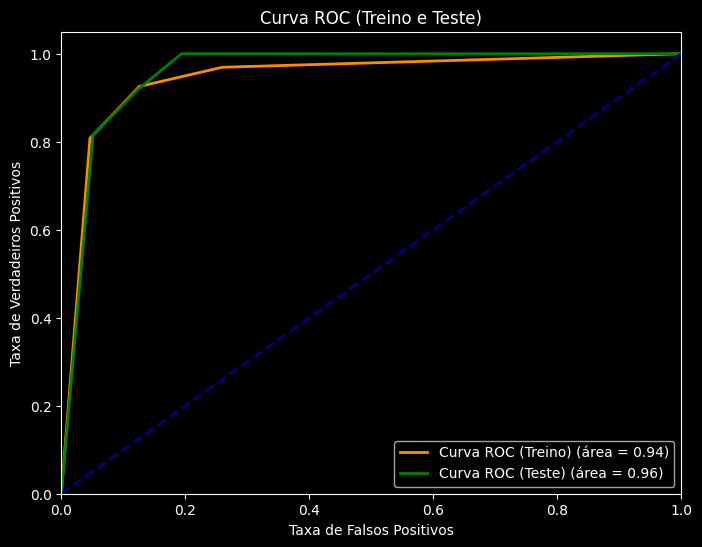

In [ ]:
modelo_knn_upgrade = KNeighborsClassifier(n_neighbors=3)
modelo_knn_upgrade.fit(X_train_transformed, y_train)

# Avaliar o modelo
treinar_e_avaliar_modelo(modelo_knn_upgrade, X_train_transformed, y_train, X_test_transformed, y_test)

## Escolha do melhor Modelo de IA

### Avaliação 🎲

Foi avaliado os 2 modelos: KNN e Random Forest

A avaliação foi realizada utilizando os dados equilibrados e sem estar equilibrados.

- Random Forest – Sem equilibrar os dados

 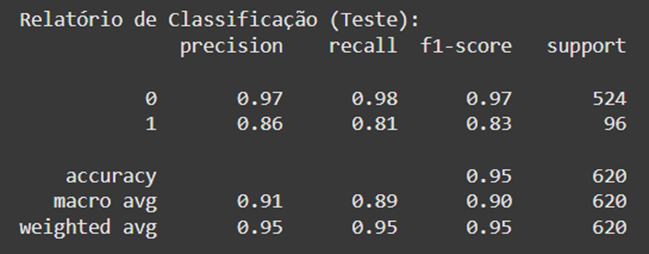

- KNN– Sem equilibrar os dados

 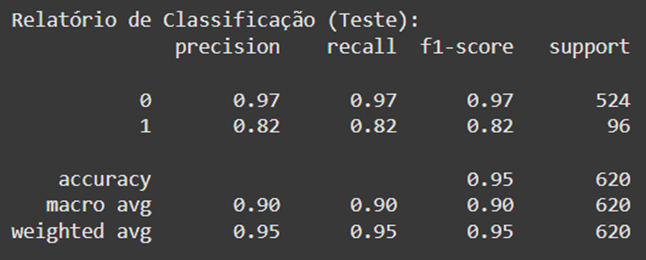

- Random Forest – Dados equilibrados

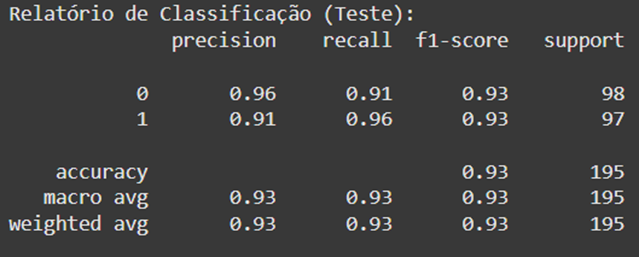

- KNN – Dados equilibrados

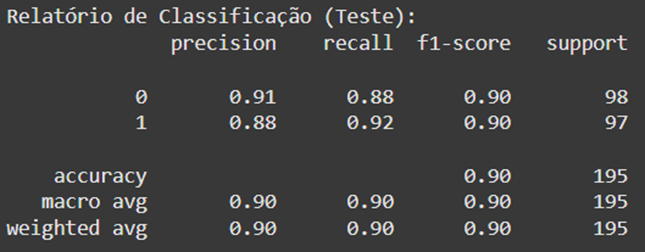

## Conclusão 🎯

Ambos os modelos sem equilibrar os dados estavam muito próximos, porém a assertividade para os clientes "churn" estava um pouco baixa.

Após equilibrar os dados, as métricas melhoraram bastante com relação a identificação dos clientes que deixariam a base da empresa.

Mas a diferença dos modelos após os dados estarem equilibrados mudou bastante e o Ramdom Forest se mostrou muito superior.

# Exportar o modelo de IA

In [ ]:
import pickle

# Salve a pipeline
filename = 'modelo_upgrade.pkl'
pickle.dump(modelo_upgrade, open(filename, 'wb'))